In [1]:
!pip install p3_data

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [6]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [12]:
# Load result files from P3 Test Driver
src_files = []
#src_files += ['../../no_netty_comparison/28april-Dirt/better_batching_38tests/p3_test_driver/results/*.json']
src_files += ['../../../no_netty_comparison/28april-Dirt/no_netty_100b_18tests_Dirt/p3_test_driver/results/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 23 files...


In [13]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [14]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [15]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [16]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'kubernetes', 'localWorker', 'max_test_attempts',
       'noop', 'numWorkers', 'omb_results', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'ssh_host',
       'ssh_identity_file', 'ssh_user', 'status_html', 'tarball',
       'terraform', 'test', 'test_attempt', 'test_batch_uuid',
       'test_desc', 'test_driver_log_filename', 'test_driver_version',
       'test_uuid', 'undeploy', 'utc_begin', 'utc_end', 'loaded_filename',
       'driverName', 'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', 'topics',
       'aggregatedEndToEndLaten

In [17]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pravegaVersion',
]

In [18]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [19]:
cols = param_cols + output_cols

In [22]:
# View most recent results
clean_df[cols].tail(24).T

test_uuid,429e8171-c210-4046-ad17-afcff13b63f6,1e742647-fc85-414a-98d2-16276afad326,328dca87-75d5-4fa8-8d5c-454380c21a71,9e87adfe-7b07-43a5-9d8c-d29e25f69c53,2a3aaf52-e99d-4ecb-844d-237c0d748c6a,3f881882-215a-4aa7-9715-ff0b9ebfbe63,01e3e7b5-410e-445c-ba55-56da44dd8c86,0e18bd0e-914c-43f6-8357-e813ebccdd3b,0d42b89d-c0fa-4915-8d95-e33e128f20d0,04c2ae45-5f8b-4dab-bf56-6df826675742,...,6eac1968-bf07-47b3-ac4e-ebe018c864a4,825aef1a-e924-4af0-91ee-8552876b783c,0fc5631f-7565-438d-b30f-e4e37fb60693,0765ca66-a869-4b60-b457-9500ef5d8636,4425d8b6-f046-43dc-97bc-b3bbb2e9dbfd,28c3606a-ac1b-4cb2-8eef-c7df343fead3,be994611-de50-4562-b50b-90f5c5e6f12d,d865276f-3865-485a-acfe-5fdf7d752896,8ae94d37-9ab0-4cd2-be8e-61593c2f10b5,2122b299-9081-46b6-a7b8-2045a58f0427
numWorkloadWorkers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
topics,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
partitionsPerTopic,1,16,1,16,1,16,1,16,1,16,...,16,1,16,1,16,1,16,1,16,1
producersPerTopic,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,1,1,1,1
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,1,16,1,16,1,16,1,16,1,16,...,16,1,16,1,16,1,16,1,16,1
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,7729d12,7729d12,7729d12,7729d12,7729d12,7729d12,7729d12,7729d12,7729d12,7729d12,...,b2d4454,b2d4454,b2d4454,0f33554,0f33554,0f33554,0f33554,0f33554,0f33554,0f33554
pravegaVersion,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,...,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26


In [23]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [24]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [25]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pravegaVersion']).size()

pravegaVersion
0.8.0-2527.e480f26    23
dtype: int64

In [26]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

23

In [27]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [34]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = 'No netty on Dirt, Message Size %d, partitions: %d  2min test' % (messageSize, partitionsPerTopic)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [41]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=2,
    partitionsPerTopic=16,
)

In [42]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid,5037d8c7-e851-4502-846d-878ec987e73e


In [43]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,1e742647-fc85-414a-98d2-16276afad326,5037d8c7-e851-4502-846d-878ec987e73e,4425d8b6-f046-43dc-97bc-b3bbb2e9dbfd
numWorkloadWorkers,0,0,0
topics,1,1,1
partitionsPerTopic,16,16,16
producersPerTopic,2,2,2
subscriptionsPerTopic,1,1,1
consumerPerSubscription,16,16,16
testDurationMinutes,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY
git_commit,7729d12,b2d4454,0f33554
pravegaVersion,0.8.0-2527.e480f26,0.8.0-2527.e480f26,0.8.0-2527.e480f26


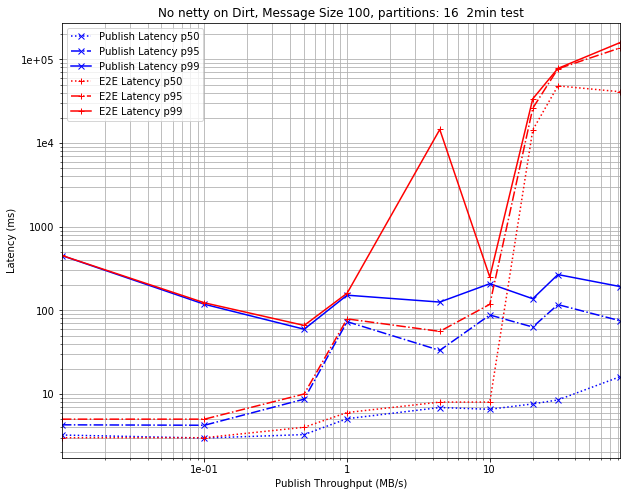

In [44]:
plot_latency_vs_throughput(filt_100_df)

In [45]:
latency_vs_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.010026,3.231,4.278,451.941,3.000,5.000,453.001,1e742647-fc85-414a-98d2-16276afad326
0.100214,2.974,4.229,118.136,3.000,5.000,123.000,9e87adfe-7b07-43a5-9d8c-d29e25f69c53
0.501200,3.270,8.676,59.464,4.000,10.000,66.000,3f881882-215a-4aa7-9715-ff0b9ebfbe63
1.002134,5.062,73.197,151.738,6.000,79.000,160.000,0e18bd0e-914c-43f6-8357-e813ebccdd3b
4.473788,6.888,33.203,125.533,8.000,56.000,14518.015,04c2ae45-5f8b-4dab-bf56-6df826675742
10.031908,6.563,87.940,208.099,8.000,118.000,250.000,5037d8c7-e851-4502-846d-878ec987e73e
20.072114,7.610,63.159,137.550,14329.023,26084.095,33750.015,6eac1968-bf07-47b3-ac4e-ebe018c864a4
30.113509,8.482,117.088,267.575,48186.111,77089.279,77964.287,0fc5631f-7565-438d-b30f-e4e37fb60693
81.830705,16.043,75.183,192.664,41055.231,136796.159,158302.207,4425d8b6-f046-43dc-97bc-b3bbb2e9dbfd


## Message Size 10 KB

In [46]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    #producersPerTopic=1,
    partitionsPerTopic=1,
)

In [47]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,28c3606a-ac1b-4cb2-8eef-c7df343fead3
numWorkloadWorkers,0
topics,1
partitionsPerTopic,1
producersPerTopic,1
subscriptionsPerTopic,1
consumerPerSubscription,1
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,0f33554
pravegaVersion,0.8.0-2527.e480f26


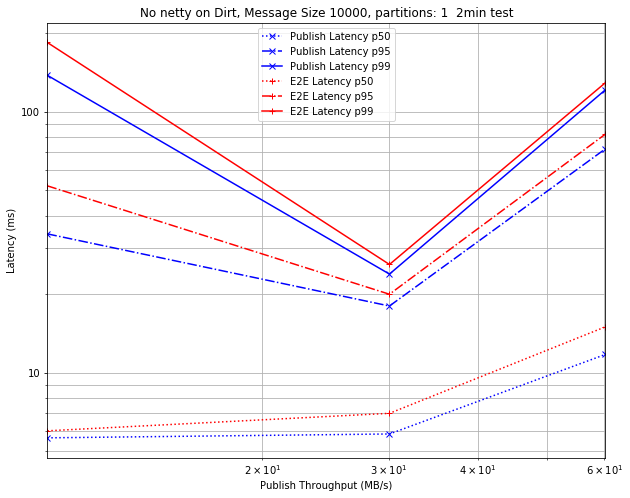

In [48]:
plot_latency_vs_throughput(filt_10000_df)

In [49]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
10.018022,5.640,34.050,137.780,6.0,52.0,184.0,28c3606a-ac1b-4cb2-8eef-c7df343fead3
30.087989,5.835,18.029,23.888,7.0,20.0,26.0,d865276f-3865-485a-acfe-5fdf7d752896
60.217552,11.762,72.031,121.206,15.0,82.0,129.0,2122b299-9081-46b6-a7b8-2045a58f0427


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [132]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

2

In [20]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

NameError: name 'filt_50000eps_df' is not defined

# Analyze Latency Distribution

In [21]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

NameError: name 'filt_50000eps_df' is not defined

In [22]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

NameError: name 'clean_df' is not defined

In [23]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

NameError: name 't' is not defined

In [24]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

NameError: name 'pubcdf' is not defined

NameError: name 'pubpdf' is not defined

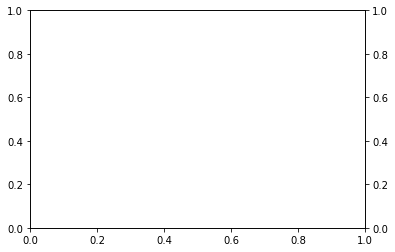

In [25]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

In [ ]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [56]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    #numWorkloadWorkers=4, 
    topics=1,
    testDurationMinutes=2,
    size_of_test_batch=(2,1000), # between
    aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    #producersPerTopic=1,
    partitionsPerTopic=1,    
)
len(filt_df)
filt_df.iloc[0].pravegaVersion

'0.8.0-2527.e480f26'

In [57]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.8.0-2527.e480f26',
)
len(filt1_df)

9

In [28]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2386.23b7340',
)
len(filt2_df)

NameError: name 'filt_df' is not defined

In [29]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

NameError: name 'filt1_df' is not defined

In [30]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [31]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

NameError: name 'filt1_df' is not defined

In [32]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')

NameError: name 'filt1_df' is not defined